# Internet Firewall Protection 
Patricia Attah, Eric Romero

### Table of Contents:

   * <a href="#1"> Business Understanding </a>
   * <a href="#2"> Data Evaluation/Engineering </a>
   * <a href="#3"> Modeling Preparations </a>
   * <a href="#4"> Model Building and Evaluation </a>
   * <a href="#5"> Model Interpretability and Explainability </a>
   * <a href="#6"> Case Conclusions </a>

<a id="1"></a>
## Business Understanding


### Task Summary:
* Use SVM and SGD to attempt to model and predict the class of an internet connection request.
* Target attribute is "Action", a successful connection request is categorized as "allow"
* Report on the level of accuracy and the level of performance so that they can make the decision on whether or not this can be implemented.

It was requested to build an algorithm that identifies which connection to allow thru the company’s firewall and on to its network. The company wishes to automate this process in order to lower the costs from their current processes, and request the algorithm be the most accurate and “function at speed.” We were given 65,532 rows of observations in 12 columns to train and test of models and will need to report level of accuracy and level of performance so the company can decide whether to implement our algorithm
 

<a id="2"></a>
## Data Evaluation / Engineering

1. Checked for missing values 
2. Checked for correlations
3. Removed outliers
4. Checked VIF
5. Check for unbalanced target values

After analysis of our data, We checked for missing values there were none missing. We now checke pearson correlations to see if the highly correlated features can be removed (one of them), we found that the variables bytes, bytes_sent, packets, packets_sent, packets_recieved and bytes reacived were all highly correlated, before removing those variables we wanted to check the VIF to see what was happening, those same values had a high VIF, so our first action were to remove the outliers that were found during the summurization of the data. After removing the outliers the VIF was still high so we decided to remove the variables 'Bytes Sent','Bytes Received','pkts_received','pkts_sent' this was the only action that would reduce the VIF to below 10 so that the model would not suffer from multicolinearity. 

After summerising our data we noticed some outliers since the median values of some variables were extremely much lower than the max value, this anomaly will lead to mis leading results. The three variables that stood out were 'Packets', 'packs_sent' and 'pkts_recieved, which each had a median value of 102.8, 41.4 and 61.4 respectivley but had extremly large max values of 1.0361160e+06, 747520 and 327208. (The outliers were removed from the model) 

We re-categorized “drop”, “deny”, and “reset-both” actions into one grouping which will represent our connection we will not allow. The aggregate amount of this combined group (27,892) will add more balance to data since observations with “allow” has 37,640 observations. 

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import average_precision_score
import seaborn as sns

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, roc_curve,roc_auc_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('log2.csv')
df.shape

(65532, 12)

In [3]:
df.head(5)

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [4]:
for c in df.columns:
    print('{} is formatted as a(n) {}'.format(c, df[c].dtype))

Source Port is formatted as a(n) int64
Destination Port is formatted as a(n) int64
NAT Source Port is formatted as a(n) int64
NAT Destination Port is formatted as a(n) int64
Action is formatted as a(n) object
Bytes is formatted as a(n) int64
Bytes Sent is formatted as a(n) int64
Bytes Received is formatted as a(n) int64
Packets is formatted as a(n) int64
Elapsed Time (sec) is formatted as a(n) int64
pkts_sent is formatted as a(n) int64
pkts_received is formatted as a(n) int64


In [5]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [6]:
#Checking for missing values
df.isnull().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

In [7]:
df['Action'].value_counts()

allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

In [8]:
#Re-categorizing target category into allowed & not-allowed = 1 & 0
clean_df = df
clean_df['Action'] = clean_df['Action'].replace('allow', 1)
clean_df['Action'] = clean_df['Action'].replace('drop', 0)
clean_df['Action'] = clean_df['Action'].replace('deny', 0)
clean_df['Action'] = clean_df['Action'].replace('reset-both', 0)
clean_df['Action'].value_counts()

1    37640
0    27892
Name: Action, dtype: int64

We re-categorized “drop”, “deny”, and “reset-both” actions into one grouping which will represent our connection we will not allow. The aggregate amount of this combined group (27,892) will add more balance to data since observations with “allow” has 37,640 observations. 

* Given that the task priority is to predict successful connections the multiple categories were re-categorized into allowed or not allowed.

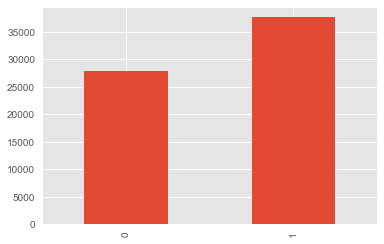

In [53]:
# checking the balance of the target variables - it is well balanced
clean_df['Action'].value_counts().plot(kind='bar');

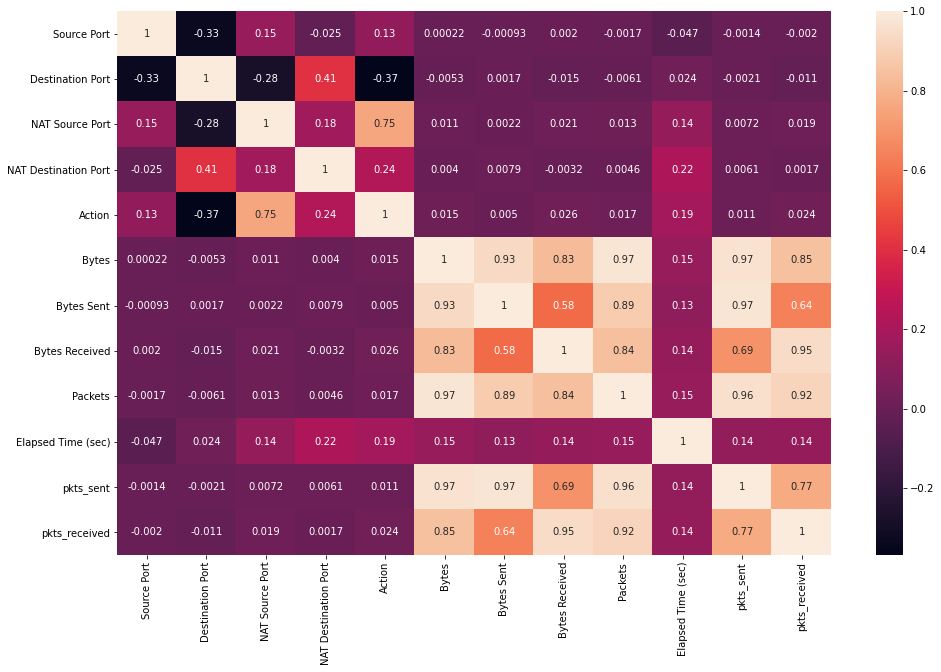

In [10]:
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(16,10))

sns.heatmap(corrMatrix, annot=True)
plt.show()

We now checke pearson correlations to see if the highly correlated features can be removed (one of them), we found that the variables bytes, bytes_sent, packets, packets_sent, packets_recieved and bytes reacived were all highly correlated,

In [11]:
cl3 = clean_df.drop(['Action'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = cl3.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(cl3.values, i)
                          for i in range(len(cl3.columns))]
print(vif_data)

                 feature       VIF
0            Source Port  2.164086
1       Destination Port  1.559886
2        NAT Source Port  2.036380
3   NAT Destination Port  1.474697
4                  Bytes       inf
5             Bytes Sent       inf
6         Bytes Received       inf
7                Packets       inf
8     Elapsed Time (sec)  1.139073
9              pkts_sent       inf
10         pkts_received       inf


The six variables bytes, bytes_sent, packets, packets_sent, packets_recieved and bytes reacived with INF had extremly high VIF and are being considered to be removed however before then we decide to fix the outliers to see if that would reduce the VIF scores

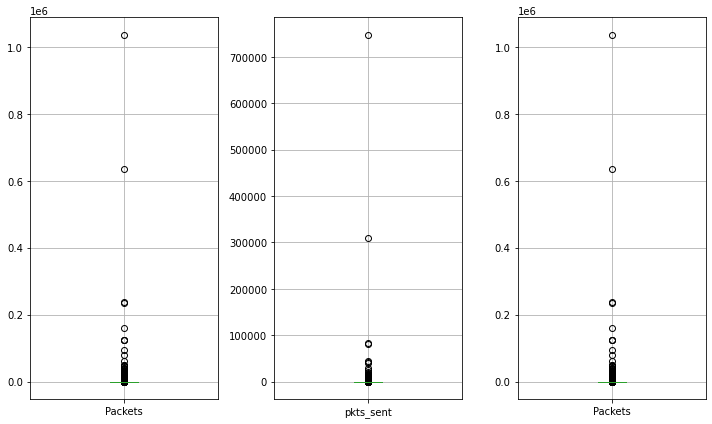

In [12]:
# Visualize Outliers

fig, axs = plt.subplots(2,1,figsize=(10,6))
plt.subplot(1, 3, 1)
clean_df.boxplot(column=['Packets'])
plt.subplot(1, 3, 2)
clean_df.boxplot(column=['pkts_sent'])
plt.subplot(1, 3, 3)
clean_df.boxplot(column=['Packets'])

plt.tight_layout()

In [13]:
# remove Outliers

q = df["Packets"].quantile(0.99)
cl1 = df[df["Packets"] < q]

q2 = cl1["pkts_sent"].quantile(0.99)
cl2 = cl1[cl1["pkts_sent"] < q2]

q3 = cl2['pkts_received'].quantile(0.99)
cl3 = cl2[cl2['pkts_received'] < q3]

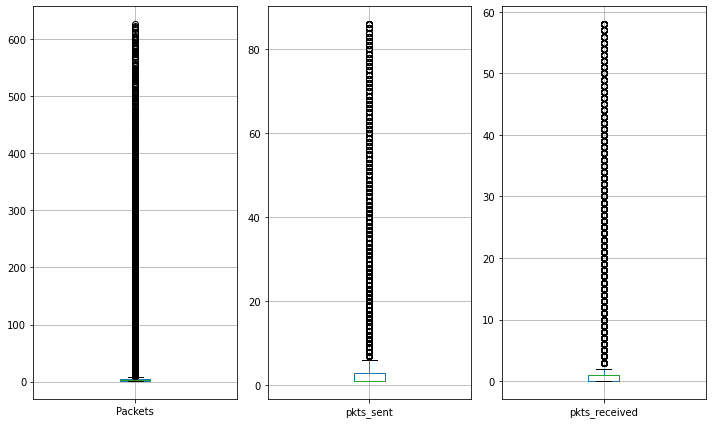

In [14]:
fig, axs = plt.subplots(2,1,figsize=(10,6))
plt.subplot(1, 3, 1)
cl1.boxplot(column=['Packets'])
plt.subplot(1, 3, 2)
cl2.boxplot(column=['pkts_sent'])
plt.subplot(1, 3, 3)
cl3.boxplot(column=['pkts_received'])

plt.tight_layout()

After removing the outiers the VIF were checked with the full model and they were still high so we removed the variables 'Bytes Sent','Bytes Received','pkts_received','pkts_sent'.  

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [16]:
# removed highly correalted variables and outliers to reduce VIF

cl3 = cl3.drop(['Action','Bytes Sent','Bytes Received','pkts_received','pkts_sent'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = cl3.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(cl3.values, i)
                          for i in range(len(cl3.columns))]
print(vif_data)

                feature       VIF
0           Source Port  2.223395
1      Destination Port  1.564258
2       NAT Source Port  2.208836
3  NAT Destination Port  1.501877
4                 Bytes  4.468777
5               Packets  5.563901
6    Elapsed Time (sec)  1.206807


In [17]:
#plt.figure(figsize=(10,8), dpi= 80)
#sns.pairplot(df)
#plt.show()

<a id="3"></a>
## Modeling Preparations

Given the large amount of data we are planning to use a support vector machine and make comparisons with a stochastic gradient descent model.

The usefulness of a support vector machine is to draw hyperplanes and create the largest margin between the dividing line and data points to improve classifications. Stochastic Gradient Descent offers advantages in terms of converging faster on very large datasets and is typically easier to implement.

<b>Models</b>
1. Support Vector Machines (SVG)
2. Stochastic Gradient Descent (SGD)

<b>Metrics</b><br>

Our evaluation metrics would be accuaracy, recall and F1 measure. The critical metric is the recall which identifies the false positives, this would mean our model predicted that the company should allow the request when the request to the firewall should have been denied since this is a cybersecurity company it could lead to severe results if a cyberattack is carried out since our model did not predict the true positives correctly. the F1 measure gives a general balance of the overall model on how well the False negatives and positives performed on the data and the accuracy gives us the how well the model identiied the true posistives and true negatives
 

<b>Therefore since we are trying to limit our False Positives the most relevant metric would be the recall</b>.<br>

1. Accuracy
2. F!
3. Recall (Critical Metric)



In [18]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.model_selection import train_test_split

X = clean_df.drop(['Action','Bytes Sent','Bytes Received','pkts_received','pkts_sent'], axis=1)
y = clean_df['Action']

#splitting data into train/test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

<a id="4"></a>
## Modeling Building and Evaluation


<b>Support Vector Machines & Hyperparameters </b><br>
1. Regularization parameter (C)
2. Kernal = kernel type to be used in the algorithm
3. Degree = Degree of the polynomial kernel function
4. Gamma = Kernel coefficient

For large values of the regularization parameter (C), the penalty becomes higher for misclassifying points which means the decision boundary will better separate the data. The degree parameter requires the use of the 'poly' kernal with a kernal coefficient using the inverse of the number of features which was small for this dataset.

<b>Stochastic Gradient Descent (SGD) & Hyperparameters </b><br>
1. max_iter = The algorithm stops after a maximum number of iterations
2. tol = The improvement is evaluated with absolute tolerance (tol)
3. loss = hinge; used to maximize the margin between decision boundaries and the data points for classification
4. penalty = l2; used to reduce overfitting on the training set

<b> Sampling Method </b><br>
Due to the multiple categories in the target class these were recategorized into a "not-accepted" class.  We implemented a k-fold cross validation with a shuffle to reduce overfitting to make sure that the model perfomed the same over every section of the data and resolve any differences in metrics due to possible imbalances in the sample splits.

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

In [20]:
from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) 

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set


#### Support Vector Machines (SVM)

In [25]:
%%time
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=100, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

CPU times: user 3.48 s, sys: 56.8 ms, total: 3.53 s
Wall time: 3.57 s


SVC(C=100, gamma='auto', kernel='linear')

#### K-fold Cross Validation

In [29]:
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

#cv = KFold(n_splits=10, random_state=42, shuffle=True)

scores = cross_val_score(svm_clf, X_train_scaled, y_train, scoring='recall',  n_jobs=-1)
print('Accuracy: %.3f' % (mean(scores)))

Accuracy: 0.997


In [30]:
y_pred = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_pred)
rec = mt.recall_score(y_test,y_pred)
pre = mt.precision_score(y_test,y_pred)
conf = mt.confusion_matrix(y_test,y_pred)

print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9207
           1       1.00      1.00      1.00     12419

    accuracy                           1.00     21626
   macro avg       1.00      1.00      1.00     21626
weighted avg       1.00      1.00      1.00     21626



array([[ 9201,     6],
       [   51, 12368]])

In [32]:
column_names = X.columns.tolist()
zip_vars = zip(svm_clf.coef_.T,column_names) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) 

Destination Port has weight of -0.582438566575334
Source Port has weight of 0.0006061276666287085
Bytes has weight of 0.3991289442581367
NAT Destination Port has weight of 0.9229494762687764
NAT Source Port has weight of 2.443498986307162
Packets has weight of 3.8571118983763903
Elapsed Time (sec) has weight of 68.69199385199394


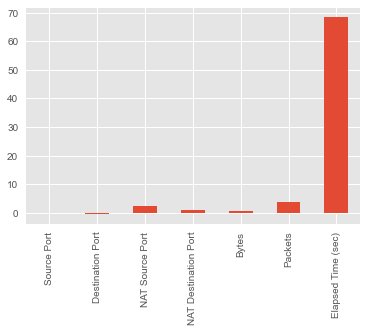

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(svm_clf.coef_[0],index=column_names)
weights.plot(kind='bar')
plt.show()

In [34]:
# training data
df_tested_on = clean_df
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286 entries, 66 to 43795
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Source Port           286 non-null    int64
 1   Destination Port      286 non-null    int64
 2   NAT Source Port       286 non-null    int64
 3   NAT Destination Port  286 non-null    int64
 4   Action                286 non-null    int64
 5   Bytes                 286 non-null    int64
 6   Bytes Sent            286 non-null    int64
 7   Bytes Received        286 non-null    int64
 8   Packets               286 non-null    int64
 9   Elapsed Time (sec)    286 non-null    int64
 10  pkts_sent             286 non-null    int64
 11  pkts_received         286 non-null    int64
dtypes: int64(12)
memory usage: 29.0 KB


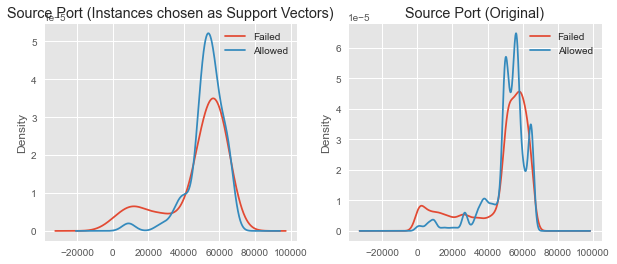

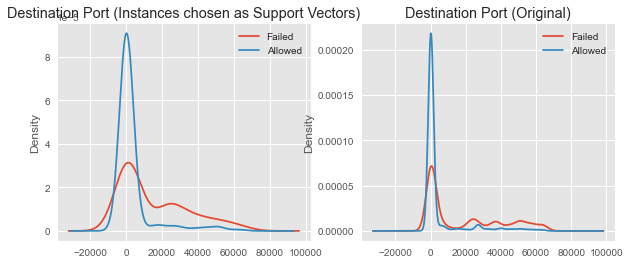

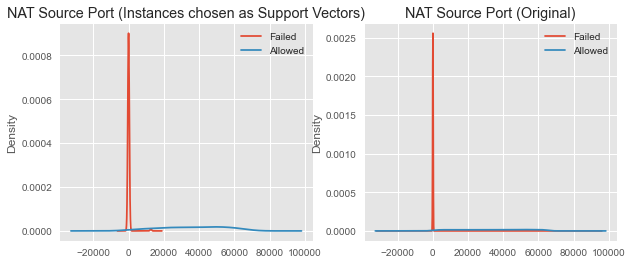

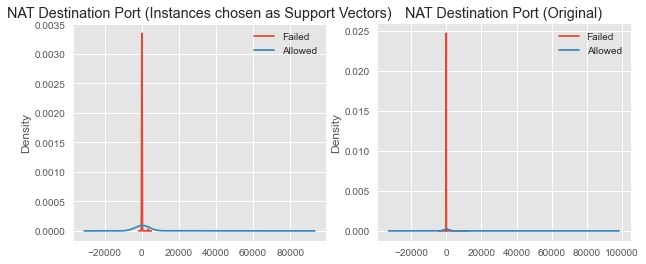

In [35]:
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['Action'])
df_grouped = clean_df.groupby(['Action'])

# plot KDE of Different variables
vars_to_plot = ['Source Port','Destination Port','NAT Source Port','NAT Destination Port']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Failed','Allowed'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Failed','Allowed'])
    plt.title(v+' (Original)')

Here we see the original statistics for the data along with the support vectors. The support vector distributions are still somewhat differed from the original indicating there was some misclassifiactions however in general the predicted support vectors were in most cases similar to the orginal so iyt seems generally boundaries were correctly predicted in the orginal data the boundaries were not perfectly clear so there were leaks of one target values in crossing the others boundaries   

#### Stochastic Gradient Descent (SGD)

In [36]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [37]:
from sklearn.model_selection import KFold
clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-5,loss="hinge", penalty="l2"))

clf.fit(X_train_scaled, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(tol=1e-05))])

#### K-fold Cross Validation

In [51]:
from sklearn.model_selection import StratifiedKFold
strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(X, y)
scores = []

In [52]:
for k, (train, test) in enumerate(kfold):
    clf.fit(X.iloc[train, :], y.iloc[train])
    #score = clf.score(X.iloc[test, :], y.iloc[test])
    score = cross_val_score(clf, X.iloc[test, :], y.iloc[test],scoring='recall')
    scores.append(score)
    print(score)
index = 0 

for i in scores:
    print('Recall per iteration',index,':' ,mean(scores[index]))
    index += 1
    
#print('Average Recall',mean(score))

[0.99203187 0.99734396 0.99203187 1.         0.99601064]
[0.99734396 1.         0.99867198 0.99601594 0.99601064]
[0.99335989 0.99734396 0.99601594 0.99867021 0.99734396]
[0.99867198 0.99734396 0.99468792 0.99069149 0.99867198]
[0.99867198 0.9814077  0.99734396 0.99601064 1.        ]
[0.99335989 0.99601594 0.99601594 0.99734043 0.99601594]
[0.99468792 0.99203187 0.99601594 0.99601064 0.99601594]
[0.99867198 0.99468792 0.99734396 0.99335106 0.99601594]
[0.99468792 0.99601594 0.99867198 0.99867021 0.99335989]
[0.99867198 0.99335989 0.99601594 0.99601594 0.9893617 ]
Recall per iteration 0 : 0.9954836681642225
Recall per iteration 1 : 0.9976085021615665
Recall per iteration 2 : 0.9965467915571755
Recall per iteration 3 : 0.9960134638749965
Recall per iteration 4 : 0.9946868554152186
Recall per iteration 5 : 0.9957496256110311
Recall per iteration 6 : 0.9949524596648865
Recall per iteration 7 : 0.9960141702692775
Recall per iteration 8 : 0.9962811873075076
Recall per iteration 9 : 0.9946850

In [40]:
y_pred_test = clf.predict(X_test_scaled)

In [41]:
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_test))
confusion_matrix(y_test, y_pred_test)

              precision    recall  f1-score   support

           0       0.43      1.00      0.60      9207
           1       1.00      0.00      0.00     12419

    accuracy                           0.43     21626
   macro avg       0.71      0.50      0.30     21626
weighted avg       0.76      0.43      0.25     21626



array([[ 9207,     0],
       [12417,     2]])

In [42]:
zip_vars = zip(clf.named_steps['sgdclassifier'].coef_.T,column_names) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) 

Destination Port has weight of -0.3624739140760474
Source Port has weight of 0.008545743159729896
Bytes has weight of 0.1575870423236865
Packets has weight of 0.3309908958690763
NAT Destination Port has weight of 1.7334937559085097
NAT Source Port has weight of 5.73190461596893
Elapsed Time (sec) has weight of 13.16164232007133


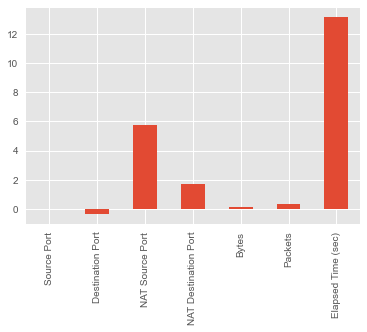

In [43]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(clf.named_steps['sgdclassifier'].coef_[0],index=column_names)
weights.plot(kind='bar')
plt.show()

<a id="5"></a>
## Model Intepretability & Explainability

The Model for the SVM performed well in general with 1.0 in recall 0.99 in precision, it also had a perfect score for the f1 measure. We were not able due to the parameters being used and the results to run a cross validation on the SVM to see if the model was suffering from overfitting, beacause historically SVM take extremely long to run and ang a great amout of computing power this would not be feasible due to our inadequate  the SVM had F1 of 1.00  and an accuracy of 1.00

While the SGD model performed well  precision to be allowed hence it detected the false negatives perfectly for the allowed case but performed poorly with 0.43 in the identifying the precision of the cases that were not allowed so there were a high number of false negatives which not so severe since it did not allow a server request that should have been allowed. While for the recall it performed well on identifing the false positives for the request that should be denied with 1.0 while it fell flat with 0.0 recall in requets that should have been allowed. this model has a F1 score of 0.60 and an accuracy of 0.43

In conclusion the SVM model perforemed better in all metrics accessed, precision, recall, accuracy and F1. 

### Coefficients
For the top three variables two of them were the same for both SGD and SVM which were time Elapsed Time and NAT Source Port. For the SGD the variables  were Elapsed Time with a weight of 13.161,NAT Source Port with a weight of 5.73 and NAT Destination Port with a weight of 1.733.<br> 
While for the SVM the most influential varibale by far was the Elapsed Time with a weight of 68.69 the next was NAT Source Port with a weight of 2.44 and Packets with a weight of 3.85.


In [44]:
Model_compare = pd.DataFrame(
{'Model': ['Support Vector Machines (SVG)','Stochastic Gradient Descent (SGD)'],
'Precision[Not-Accepted]': ['0.99','0.43'],
'Recall[Not-Accepted]': ['1.00','1.00'],
'Precision[Accepted]': ['1.00','1.00'],
'Recall[Accepted]': ['1.00','0.00'],
'Accuracy': ['1.00','0.43'],
})
pd.set_option("max_colwidth", 3000)

Model_compare


,Model,Precision[Not-Accepted],Recall[Not-Accepted],Precision[Accepted],Recall[Accepted],Accuracy
0,Support Vector Machines (SVG),0.99,1.0,1.0,1.0,1.00
1,Stochastic Gradient Descent (SGD),0.43,1.0,1.0,0.0,0.43


<a id="6"></a>
## Conclusions


We see that the best model is the SVM model which performed better in every metric however overfitting should be looked into to make sure the model is producing accurate results as due to compatibilty of the model and system the cross validatin was not able to run on the model to ensure every part of the data was accurately accesed, The SGD model on the hand had been cross validated but performed poorly in recall F1 and accuracy. 

From the coefficients we see that when looking into protection from unwanted server requests we should take into consideration the most importantly the Elapsed Time and the NAT Source Port, these could be key factors in determined an effective protective firewall program to create wile the SVM aso tels us the Packets is important too and shoud be studied further